# Categorical Model Prediction

The main of this notebook is to show different models of machine learning in order to find the best model to predict the sector of the company.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import lightgbm as lgb

%matplotlib inline

In [2]:
def add_shifts(df_, col_to_shift, new_col, shift):
    """
    This function add shifted columns to data by ticker.
    
    :param pd.DataFrame df_: Dataframe with financial data.
    :param str col_to_shift: Column over to create the shift.
    :param str new_col: Name of the shifted column.
    :param int shift: Days to use as shift.
    :return pd.DataFrame: Dataframe with the shift added.
    """
    
    for id_ in df_['ticker'].unique():
        df_by_id = df_[df_['ticker'] == id_]
        df_.loc[df_['ticker'] == id_, new_col] = df_by_id[col_to_shift] - df_by_id[col_to_shift].shift(shift)
        
    return df_

In [3]:
def get_non_42_cols(df_):
    """
    Get the columns that his window is not 42 days
    
    :param pd.DataFrame df_: Dataframe with financial data.
    :return list: List with the name of the columns.
    """
    
    return [elem for elem in df_.columns if (re.search(r'\d+$', elem) is not None) and (int(elem[-2:].strip()) != 42)]

In [4]:
def interpolate_nan_values(df_):
    """
    Interpolate and extrapolate nan values for all numerical columns.
    
    :param pd.DataFrame df_: Dataframe with financial data with NaN values.
    :return pd.DataFrame: Dataframe with financial data without NaN values.
    """
    
    list_df = []
    for tick in df_['ticker'].unique():
        df_by_ticker = df_[df_['ticker'] == tick]
        float_columns = df_by_ticker.select_dtypes(float).columns
        for col in float_columns:
            df_by_ticker[col] = df_by_ticker[col].interpolate(method='nearest', limit_direction='both')
        list_df.append(df_by_ticker)
    return pd.concat(list_df)

In [5]:
def get_correlated_columns(df_):
    """
    This function calculate the correlation between variables and provided a dict
    with more correlated features by key.
    
    :param pd.DataFrame df_:  Dataframe with correlation info.
    :return dict: Dictionary where keys are columns and values are their correlated features.
    """
    
    df_ = df_.drop('close', axis=1)
    df_ = df_.drop('close', axis=0)
    dict_ = {}
    df__ = df_[df_ >=.9]
    df__ = df__[df__ < 1].dropna(axis=1, how='all').dropna(axis=0, how='all')
    list_ = list(df__.columns)
    for col in list_:
        dict_[col] = list(df__[df__[col].notnull()].index)
        for elem in dict_[col]:
            if elem in list_:
                list_.remove(elem)
    return dict_

In [6]:
df_categorical = pd.read_csv('../data/db_bsm_categorical.csv')
df_financial = pd.read_csv('../data/db_bsm_financial.csv')

In [7]:
print('Total features: %i' % df_financial.shape[1])

Total features: 148


Firstly let's to reduce the features and take only wich his temporary window is 42 days

In [8]:
list_cols_to_drop = get_non_42_cols(df_financial)
df_financial = df_financial.drop(list_cols_to_drop, 1)

In [9]:
print('Total features: %i' % df_financial.shape[1])

Total features: 38


Let's check null values

In [10]:
# Considering 0 values as NaN because this means an error during the downloading
df_financial = df_financial.replace(0, np.nan)

In [11]:
df_financial.isnull().sum().to_frame('Null Values').sort_values(by='Null Values', ascending=False).head(3)

,Null Values
Aroon Down 42,31122
Aroon Up 42,21207
BOP 42,8085


As we can see in the previous cell me have many null values. To solving that let's to interpolate and extrapolate the values

In [12]:
df_financial_no_empty = interpolate_nan_values(df_financial)

In [13]:
df_financial_no_empty.isnull().sum().to_frame('Null Values').sort_values(by='Null Values', ascending=False).head(3)

,Null Values
BOP 42,178
volume,134
Aroon Down 42,38


In [14]:
# Next let's calculate the p&l. This will create NaN's at the begining of the ts but we are going to ignore those
df_financial_no_empty = add_shifts(df_financial_no_empty, 'close', 'daily_pl', 1)

In [15]:
df_categorical = df_categorical.dropna()
df_categorical = df_categorical.drop_duplicates(subset=['ticker'], keep='first')

In [16]:
df_fin_cat = pd.merge(left=df_financial_no_empty, right=df_categorical, how='inner', on='ticker')

In [17]:
# Drop all nulls values
df_fin_cat = df_fin_cat.dropna()

In [18]:
target = df_fin_cat['sector_gics'].values
features = df_fin_cat.select_dtypes(float).values
features_col = df_fin_cat.select_dtypes(float).columns
features_rs = RobustScaler().fit_transform(features)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=32)
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(features_rs, target, test_size=0.1, random_state=32)

Let's to compare models

In [20]:
knn = GridSearchCV(KNeighborsClassifier(),
                   param_grid={'n_neighbors': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
random_forest = GridSearchCV(RandomForestClassifier(criterion='entropy'),
                   param_grid={'max_depth': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
dec_tree = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),
                   param_grid={'max_depth': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
light = GridSearchCV(lgb.LGBMClassifier(),
                   param_grid={'max_depth': range(5, 16),
                              'learning_rate': [0.1, 1, 10]}, 
                   scoring='recall_macro', 
                   cv=5)

In [21]:
print('#' * 15, ' KNN - Total ', '#' * 15)
%time knn.fit(X_train, y_train)
print('Best params are:', knn.best_params_, '\n')
knn_best = KNeighborsClassifier(**knn.best_params_)
knn_best.fit(X_train, y_train)
print(classification_report(y_test, knn_best.predict(X_test)), '\n')

print('#' * 15, ' KNN Robust Scaler - Total ', '#' * 15)
knn_best_rs = KNeighborsClassifier(**knn.best_params_)
knn_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, knn_best_rs.predict(X_test_rs)))

###############  KNN - Total  ###############
Wall time: 12min 57s
Best params are: {'n_neighbors': 5} 

                        precision    recall  f1-score   support

Communication services       0.93      0.92      0.92      1911
Consumer discretionary       0.82      0.84      0.83      6560
      Consumer staples       0.81      0.84      0.83      3706
                Energy       0.84      0.84      0.84      3507
            Financials       0.80      0.80      0.80      5002
            Healthcare       0.85      0.84      0.84      1801
           Industrials       0.77      0.73      0.75      2697
Information technology       0.87      0.84      0.85      3215
             Utilities       0.90      0.84      0.87      1213

             micro avg       0.83      0.83      0.83     29612
             macro avg       0.84      0.83      0.84     29612
          weighted avg       0.83      0.83      0.83     29612
 

###############  KNN Robust Scaler - Total  ##############

In [22]:
print('#' * 15, ' Decision Tree - Total ', '#' * 15)
%time dec_tree.fit(X_train, y_train)
print('Best params are:', dec_tree.best_params_, '\n')
dec_tree_best = DecisionTreeClassifier(**dec_tree.best_params_)
dec_tree_best.fit(X_train, y_train)
print(classification_report(y_test, dec_tree_best.predict(X_test)), '\n')

print('#' * 15, ' Decision Tree Robust Scaler - Total ', '#' * 15)
dec_tree_best_rs = DecisionTreeClassifier(**dec_tree.best_params_)
dec_tree_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, dec_tree_best_rs.predict(X_test_rs)), '\n')

###############  Decision Tree - Total  ###############
Wall time: 22min 35s
Best params are: {'max_depth': 15} 

                        precision    recall  f1-score   support

Communication services       1.00      0.97      0.98      1911
Consumer discretionary       0.94      0.90      0.92      6560
      Consumer staples       0.92      0.93      0.92      3706
                Energy       0.94      0.93      0.94      3507
            Financials       0.86      0.91      0.89      5002
            Healthcare       0.92      0.82      0.86      1801
           Industrials       0.78      0.86      0.82      2697
Information technology       0.93      0.93      0.93      3215
             Utilities       0.99      0.96      0.98      1213

             micro avg       0.91      0.91      0.91     29612
             macro avg       0.92      0.91      0.92     29612
          weighted avg       0.91      0.91      0.91     29612
 

###############  Decision Tree Robust Scaler - To

In [23]:
print('#' * 15, ' Random Forest - Total ', '#' * 15)
%time random_forest.fit(X_train, y_train)
print('Best params are:', random_forest.best_params_, '\n')
random_forest_best = RandomForestClassifier(**random_forest.best_params_)
random_forest_best.fit(X_train, y_train)
print(classification_report(y_test, random_forest_best.predict(X_test)), '\n')

print('#' * 15, ' Random Forest Robust Scaler - Total ', '#' * 15)
random_forest_best_rs = RandomForestClassifier(**random_forest.best_params_)
random_forest_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, random_forest_best_rs.predict(X_test_rs)), '\n')

###############  Random Forest - Total  ###############
Wall time: 33min 5s
Best params are: {'max_depth': 15} 

                        precision    recall  f1-score   support

Communication services       1.00      1.00      1.00      1911
Consumer discretionary       0.98      0.96      0.97      6560
      Consumer staples       0.98      0.97      0.98      3706
                Energy       0.97      0.98      0.97      3507
            Financials       0.97      0.97      0.97      5002
            Healthcare       0.97      0.91      0.94      1801
           Industrials       0.85      0.97      0.91      2697
Information technology       0.98      0.96      0.97      3215
             Utilities       1.00      1.00      1.00      1213

             micro avg       0.97      0.97      0.97     29612
             macro avg       0.97      0.97      0.97     29612
          weighted avg       0.97      0.97      0.97     29612
 

###############  Random Forest Robust Scaler - Tot

In [24]:
print('#' * 15, ' LGBM - Total ', '#' * 15)
%time light.fit(X_train, y_train)
print('Best params are:', light.best_params_, '\n')
light_best = lgb.LGBMClassifier(**light.best_params_)
light_best.fit(X_train, y_train)
print(classification_report(y_test, light_best.predict(X_test)), '\n')

print('#' * 15, ' LGBM Robust Scaler - Total ', '#' * 15)
light_best_rs = lgb.LGBMClassifier(**light.best_params_)
light_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, light_best_rs.predict(X_test_rs)), '\n')

###############  LGBM - Total  ###############
Wall time: 1h 33min 53s
Best params are: {'learning_rate': 0.1, 'max_depth': 15} 

                        precision    recall  f1-score   support

Communication services       1.00      1.00      1.00      1911
Consumer discretionary       0.99      0.97      0.98      6560
      Consumer staples       0.99      0.99      0.99      3706
                Energy       0.99      0.99      0.99      3507
            Financials       0.98      0.98      0.98      5002
            Healthcare       0.99      0.98      0.98      1801
           Industrials       0.94      0.98      0.96      2697
Information technology       0.99      0.99      0.99      3215
             Utilities       1.00      1.00      1.00      1213

             micro avg       0.98      0.98      0.98     29612
             macro avg       0.98      0.99      0.99     29612
          weighted avg       0.98      0.98      0.98     29612
 

###############  LGBM Robust Scal

## CORRELATED FEATURES

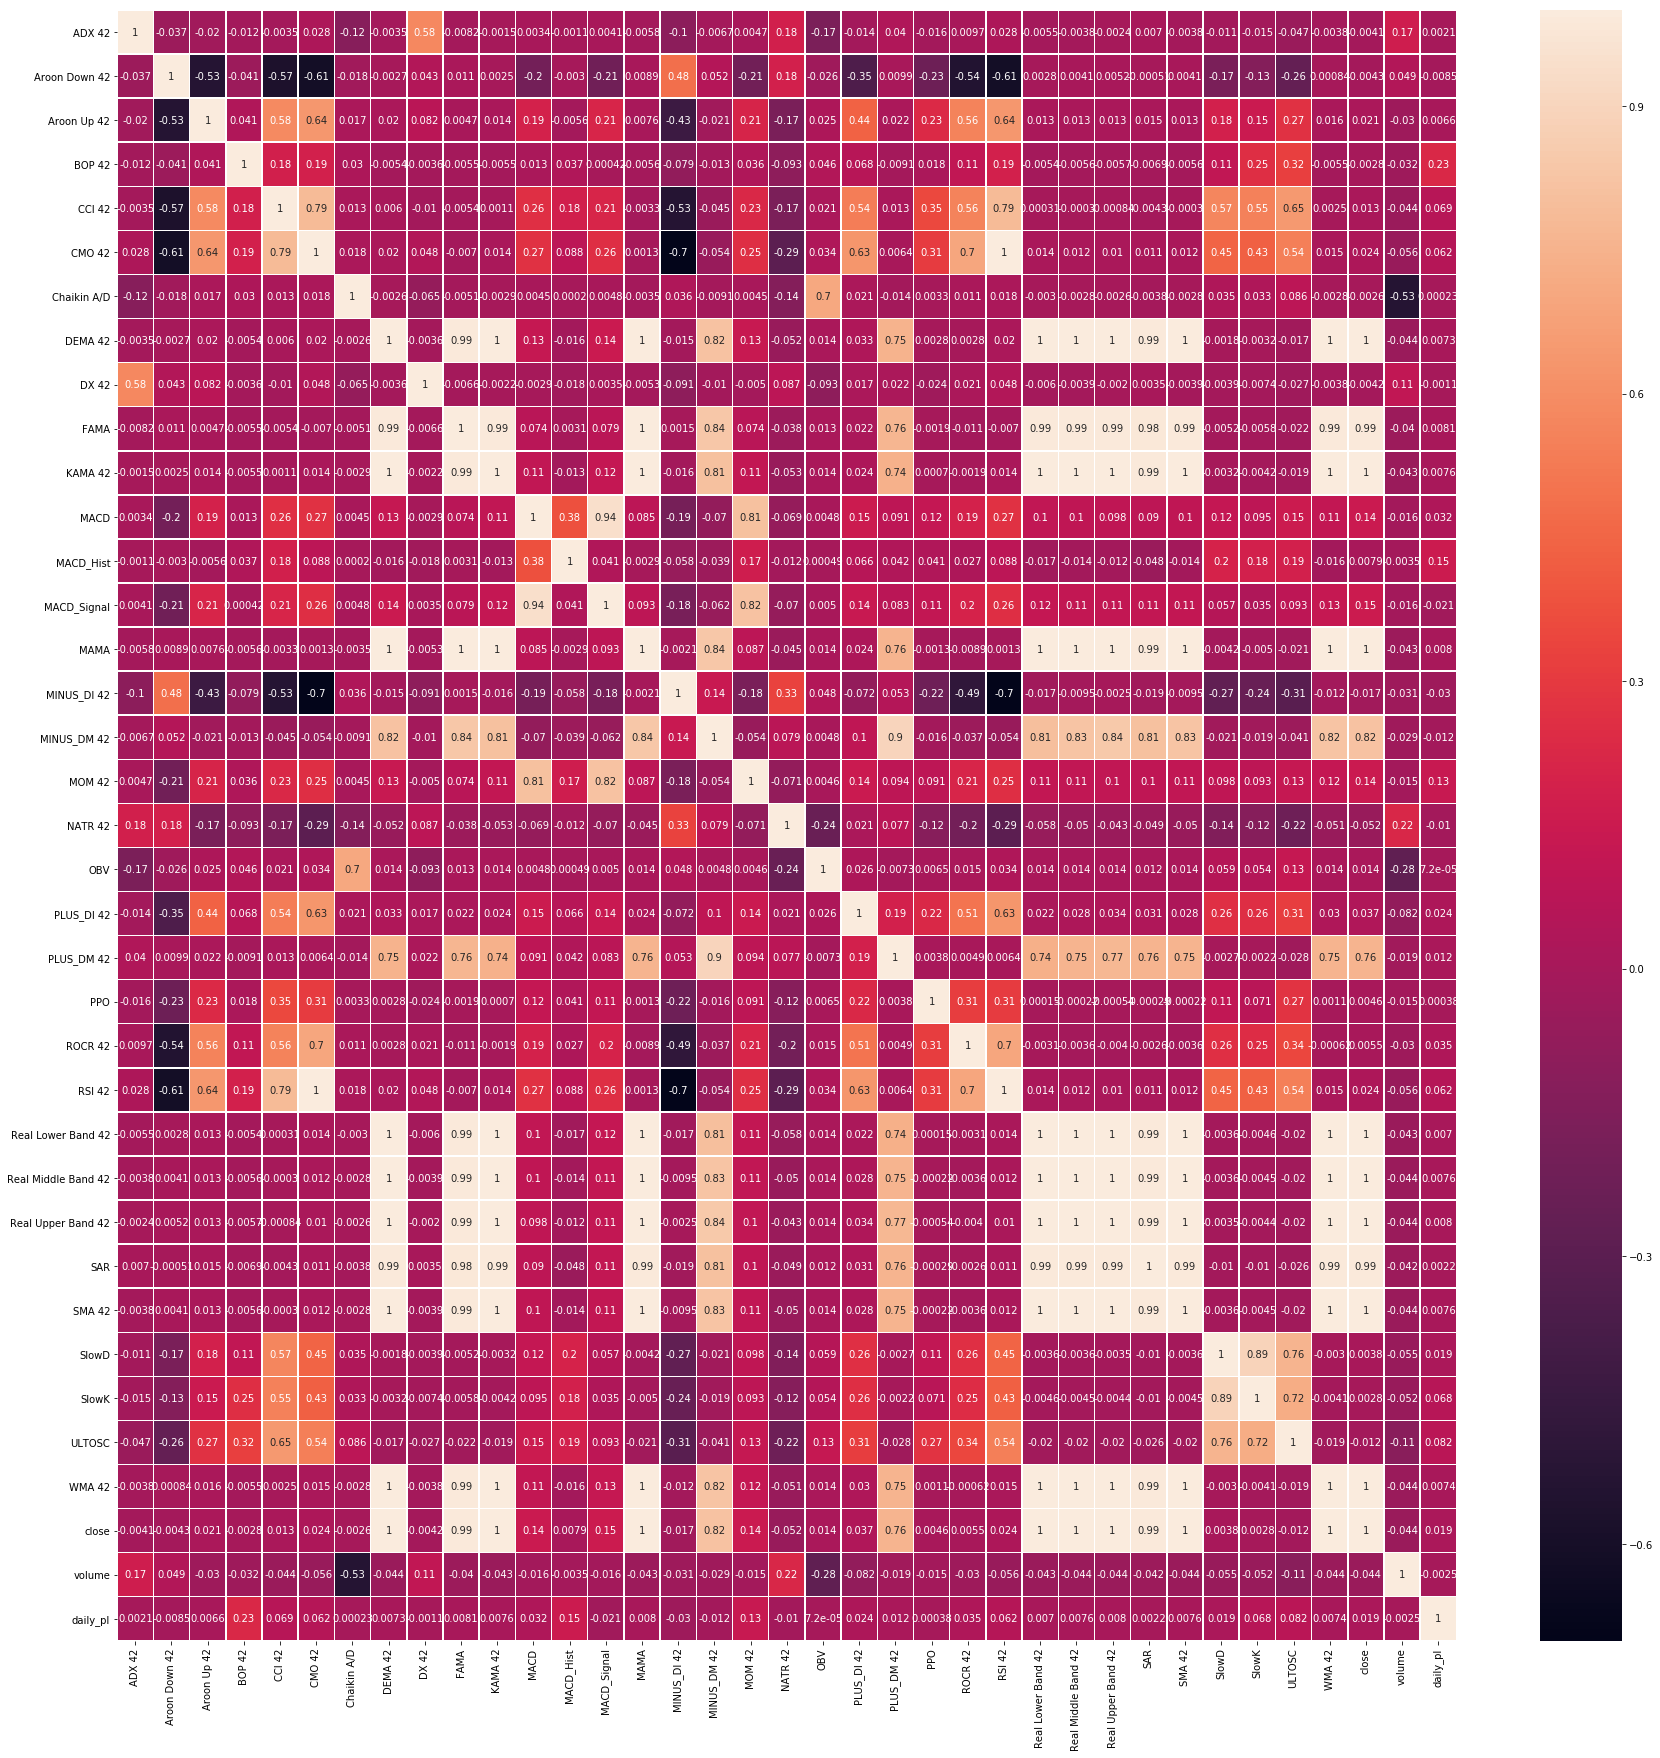

In [25]:
X_data = pd.DataFrame(data=X_train, columns=features_col)
corr = X_data.corr()
plt.figure(figsize=(30, 30))
sbn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, linewidths=.5
       )

In [26]:
dict_correlated = get_correlated_columns(corr)
cols_to_drop = [elem for sublist in dict_correlated.values() for elem in sublist]

In [27]:
target = df_fin_cat['sector_gics'].values
features_drop = df_fin_cat.drop(cols_to_drop, axis=1)
features_drop = features_drop.select_dtypes(float).values
features_col_drop = df_fin_cat.select_dtypes(float).columns
features_drop_rs = RobustScaler().fit_transform(features_drop)

In [28]:
knn = GridSearchCV(KNeighborsClassifier(),
                   param_grid={'n_neighbors': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
random_forest = GridSearchCV(RandomForestClassifier(criterion='entropy'),
                   param_grid={'max_depth': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
dec_tree = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),
                   param_grid={'max_depth': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
light = GridSearchCV(lgb.LGBMClassifier(),
                   param_grid={'max_depth': range(5, 16),
                              'learning_rate': [0.1, 1, 10]}, 
                   scoring='recall_macro', 
                   cv=5)

In [29]:
X_train_dr, X_test_dr, y_train_dr, y_test_dr = train_test_split(features_drop, target, test_size=0.1, random_state=32)
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(features_drop_rs, target, test_size=0.1, random_state=32)

In [30]:
print('#' * 15, ' KNN - Uncorrelated ', '#' * 15)
%time knn.fit(X_train_dr, y_train_dr)
print('Best params are:', knn.best_params_, '\n')
knn_best = KNeighborsClassifier(**knn.best_params_)
knn_best.fit(X_train_dr, y_train_dr)
print(classification_report(y_test_dr, knn_best.predict(X_test_dr)))

print('#' * 15, ' KNN Robust Scaler - Uncorrelated ', '#' * 15)
knn_best_rs = KNeighborsClassifier(**knn.best_params_)
knn_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, knn_best_rs.predict(X_test_rs)))

###############  KNN - Uncorrelated  ###############
Wall time: 12min 48s
Best params are: {'n_neighbors': 5} 

                        precision    recall  f1-score   support

Communication services       0.93      0.92      0.92      1911
Consumer discretionary       0.82      0.84      0.83      6560
      Consumer staples       0.81      0.84      0.83      3706
                Energy       0.84      0.84      0.84      3507
            Financials       0.80      0.80      0.80      5002
            Healthcare       0.85      0.84      0.84      1801
           Industrials       0.77      0.73      0.75      2697
Information technology       0.87      0.84      0.85      3215
             Utilities       0.90      0.84      0.87      1213

             micro avg       0.83      0.83      0.83     29612
             macro avg       0.84      0.83      0.84     29612
          weighted avg       0.83      0.83      0.83     29612

###############  KNN Robust Scaler - Uncorrelated  ##

In [31]:
print('#' * 15, ' Decision Tree - Uncorrelated ', '#' * 15)
%time dec_tree.fit(X_train_dr, y_train_dr)
print('Best params are:', dec_tree.best_params_, '\n')
dec_tree_best = DecisionTreeClassifier(**dec_tree.best_params_)
dec_tree_best.fit(X_train_dr, y_train_dr)
print(classification_report(y_test_dr, dec_tree_best.predict(X_test_dr)))

print('#' * 15, ' Decision Tree Robust Scaler - Uncorrelated ', '#' * 15)
dec_tree_best_rs = DecisionTreeClassifier(**dec_tree.best_params_)
dec_tree_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, dec_tree_best_rs.predict(X_test_rs)), '\n')

###############  Decision Tree - Uncorrelated  ###############
Wall time: 17min 17s
Best params are: {'max_depth': 15} 

                        precision    recall  f1-score   support

Communication services       0.98      0.99      0.98      1911
Consumer discretionary       0.93      0.89      0.91      6560
      Consumer staples       0.90      0.94      0.92      3706
                Energy       0.95      0.89      0.92      3507
            Financials       0.88      0.89      0.89      5002
            Healthcare       0.86      0.83      0.84      1801
           Industrials       0.79      0.88      0.83      2697
Information technology       0.91      0.92      0.92      3215
             Utilities       0.98      0.97      0.98      1213

             micro avg       0.90      0.90      0.90     29612
             macro avg       0.91      0.91      0.91     29612
          weighted avg       0.91      0.90      0.91     29612

###############  Decision Tree Robust Scaler

In [32]:
print('#' * 15, ' Random Forest - Uncorrelated ', '#' * 15)
%time random_forest.fit(X_train_dr, y_train_dr)
print('Best params are:', random_forest.best_params_, '\n')
random_forest_best = RandomForestClassifier(**random_forest.best_params_)
random_forest_best.fit(X_train_dr, y_train_dr)
print(classification_report(y_test_dr, random_forest_best.predict(X_test_dr)))

print('#' * 15, ' Random Forest Robust Scaler - Uncorrelated ', '#' * 15)
random_forest_best_rs = RandomForestClassifier(**random_forest.best_params_)
random_forest_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, random_forest_best_rs.predict(X_test_rs)), '\n')

###############  Random Forest - Uncorrelated  ###############
Wall time: 24min 42s
Best params are: {'max_depth': 15} 

                        precision    recall  f1-score   support

Communication services       0.99      0.99      0.99      1911
Consumer discretionary       0.95      0.91      0.93      6560
      Consumer staples       0.95      0.93      0.94      3706
                Energy       0.93      0.95      0.94      3507
            Financials       0.91      0.92      0.92      5002
            Healthcare       0.94      0.78      0.85      1801
           Industrials       0.75      0.93      0.83      2697
Information technology       0.94      0.91      0.92      3215
             Utilities       1.00      0.99      1.00      1213

             micro avg       0.92      0.92      0.92     29612
             macro avg       0.93      0.92      0.92     29612
          weighted avg       0.93      0.92      0.92     29612

###############  Random Forest Robust Scaler

In [33]:
print('#' * 15, ' LGBM - Uncorrelated ', '#' * 15)
%time light.fit(X_train_dr, y_train_dr)
print('Best params are:', light.best_params_, '\n')
light_best = lgb.LGBMClassifier(**light.best_params_)
light_best.fit(X_train_dr, y_train_dr)
print(classification_report(y_test_dr, light_best.predict(X_test_dr)))

print('#' * 15, ' LGBM Robust Scaler - Uncorrelated ', '#' * 15)
light_best_rs = lgb.LGBMClassifier(**light.best_params_)
light_best_rs.fit(X_train_rs, y_train_rs)
print(classification_report(y_test_rs, light_best_rs.predict(X_test_rs)), '\n')

###############  LGBM - Uncorrelated  ###############
Wall time: 1h 24min 34s
Best params are: {'learning_rate': 0.1, 'max_depth': 15} 

                        precision    recall  f1-score   support

Communication services       1.00      1.00      1.00      1911
Consumer discretionary       0.97      0.93      0.95      6560
      Consumer staples       0.97      0.97      0.97      3706
                Energy       0.97      0.98      0.97      3507
            Financials       0.95      0.95      0.95      5002
            Healthcare       0.97      0.97      0.97      1801
           Industrials       0.88      0.96      0.91      2697
Information technology       0.97      0.96      0.97      3215
             Utilities       1.00      1.00      1.00      1213

             micro avg       0.96      0.96      0.96     29612
             macro avg       0.96      0.97      0.97     29612
          weighted avg       0.96      0.96      0.96     29612

###############  LGBM Robust

## PCA

In [34]:
pca = PCA(n_components=int(X_train.shape[1]/2))

In [35]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [36]:
knn = GridSearchCV(KNeighborsClassifier(),
                   param_grid={'n_neighbors': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
random_forest = GridSearchCV(RandomForestClassifier(criterion='entropy'),
                   param_grid={'max_depth': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
dec_tree = GridSearchCV(DecisionTreeClassifier(criterion='entropy'),
                   param_grid={'max_depth': range(5, 16)}, 
                   scoring='recall_macro', 
                   cv=5)
light = GridSearchCV(lgb.LGBMClassifier(),
                   param_grid={'max_depth': range(5, 16),
                              'learning_rate': [0.1, 1, 10]}, 
                   scoring='recall_macro', 
                   cv=5)

In [37]:
print('#' * 15, ' KNN - PCA ', '#' * 15)
%time knn.fit(X_train, y_train)
print('Best params are:', knn.best_params_, '\n')
knn_best = KNeighborsClassifier(**knn.best_params_)
knn_best.fit(X_train, y_train)
print(classification_report(y_test, knn_best.predict(X_test)))

###############  KNN - PCA  ###############
Wall time: 17min 55s
Best params are: {'n_neighbors': 5} 

                        precision    recall  f1-score   support

Communication services       0.93      0.92      0.92      1911
Consumer discretionary       0.82      0.84      0.83      6560
      Consumer staples       0.81      0.84      0.83      3706
                Energy       0.84      0.84      0.84      3507
            Financials       0.80      0.80      0.80      5002
            Healthcare       0.85      0.84      0.84      1801
           Industrials       0.77      0.73      0.75      2697
Information technology       0.87      0.84      0.85      3215
             Utilities       0.90      0.84      0.87      1213

             micro avg       0.83      0.83      0.83     29612
             macro avg       0.84      0.83      0.84     29612
          weighted avg       0.83      0.83      0.83     29612



In [ ]:
print('#' * 15, ' Decision Tree - PCA ', '#' * 15)
%time dec_tree.fit(X_train, y_train)
print('Best params are:', dec_tree.best_params_, '\n')
dec_tree_best = DecisionTreeClassifier(**dec_tree.best_params_)
dec_tree_best.fit(X_train, y_train)
print(classification_report(y_test, dec_tree_best.predict(X_test)))

###############  Decision Tree - PCA  ###############


In [ ]:
print('#' * 15, ' Random Forest - PCA ', '#' * 15)
%time random_forest.fit(X_train, y_train)
print('Best params are:', random_forest.best_params_, '\n')
random_forest_best = RandomForestClassifier(**random_forest.best_params_)
random_forest_best.fit(X_train, y_train)
print(classification_report(y_test, random_forest_best.predict(X_test)))

In [ ]:
print('#' * 15, ' LGBM - PCA ', '#' * 15)
%time light.fit(X_train, y_train)
print('Best params are:', light.best_params_, '\n')
light_best = lgb.LGBMClassifier(**light.best_params_)
light_best.fit(X_train, y_train)
print(classification_report(y_test, light_best.predict(X_test)))